In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from joblib import load
from matplotlib.patches import Patch

In [2]:
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (15,10)

In [3]:
RANDOM_STATE = 42

In [4]:
def one_hot_encode_sequences(df, column_name):
    # Define a mapping from amino acids to integers
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    amino_acid_to_int = {aa: i for i, aa in enumerate(amino_acids)}
    num_amino_acids = len(amino_acids)

    encoded_sequences = []

    for sequence in df[column_name]:
        # Initialize a matrix of zeros
        encoded_matrix = np.zeros((len(sequence), num_amino_acids), dtype=int)

        for i, aa in enumerate(sequence):
            if aa in amino_acid_to_int:
                # Set the corresponding column to 1
                encoded_matrix[i, amino_acid_to_int[aa]] = 1
            else:
                raise ValueError(f"Invalid amino acid '{aa}' found in sequence.")

        encoded_sequences.append(encoded_matrix)

    return encoded_sequences

# EMI

In [5]:
score_combined = pd.read_csv('emi/emi_designs.csv', index_col=0)
score_combined.head()

,SCORE:_score,total_score,complex_normalized,dG_cross,dG_cross/dSASAx100,dG_separated,dG_separated/dSASAx100,dSASA_hphobic,dSASA_int,dSASA_polar,...,pae_binder,pae_interaction,pae_target,plddt_binder,plddt_target,plddt_total,target_aligned_rmsd,time,description_af2,n_mutations
0,SCORE:,-2150.282,-3.072,0.0,0.0,-37.630,-2.603,732.289,1445.646,713.357,...,18.951,28.266,4.585,28.555,96.465,85.309,31.935,123.731,emi_sema_complex_relax_best_0001_af2pred,4
1,SCORE:,-2147.637,-3.068,0.0,0.0,-38.368,-2.712,738.385,1414.819,676.434,...,18.931,28.280,4.567,28.506,96.481,85.313,30.917,126.860,emi_sema_complex_relax_best_0002_af2pred,5
2,SCORE:,-2147.249,-3.067,0.0,0.0,-38.141,-2.670,710.214,1428.610,718.396,...,19.080,28.261,4.559,28.260,96.465,85.260,32.118,145.013,emi_sema_complex_relax_best_0004_af2pred,4
3,SCORE:,-2150.725,-3.072,0.0,0.0,-38.308,-2.670,735.734,1434.999,699.265,...,19.012,28.311,4.511,28.446,96.586,85.392,33.492,277.104,emi_sema_complex_relax_best_0020_af2pred,5
4,SCORE:,-2137.874,-3.054,0.0,0.0,-31.838,-2.356,614.493,1351.112,736.618,...,14.147,28.366,4.618,42.159,96.496,87.570,30.203,123.609,emi_sema_complex_relax_best_0045_af2pred,5


## Predicting fitness

In [6]:
# ant for antigen binding, OVA for unspecific
emi_model = load('./emi/emi_LDA_ANT.joblib')
score_combined['encoded'] = one_hot_encode_sequences(score_combined, 'sequence')
score_combined['Flattened_Encoded'] = score_combined['encoded'].apply(lambda x: x.flatten())
X = np.stack(score_combined['Flattened_Encoded'].values)
y_pred = emi_model.predict_proba(X)
score_combined['ANT_score'] = y_pred[:,1]

emi_model_OVA = load('./emi/emi_LDA_OVA.joblib')
y_pred_OVA = emi_model_OVA.predict_proba(X)
score_combined['OVA_score'] = y_pred_OVA[:,1]

## Check predictions

/home/iwe3/anaconda3/envs/PyRosetta.notebooks/lib/python3.7/site-packages/seaborn/utils.py:279: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


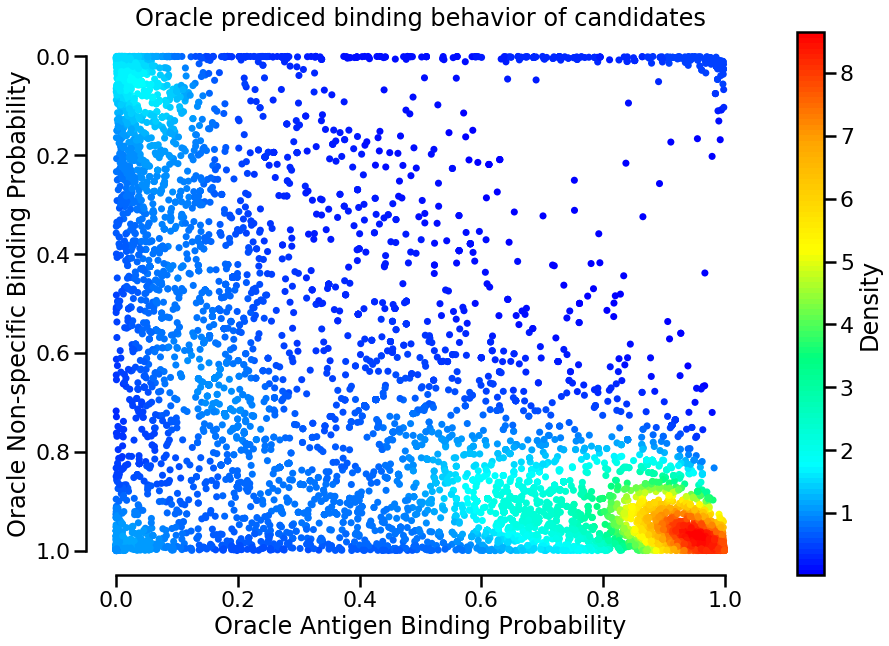

In [7]:

# Compute the point density
x = score_combined['ANT_score']
y = score_combined['OVA_score']
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)  # Compute the KDE

colors = ["blue", 'cyan', "springgreen", "yellow", "orange", "red"]
n_bins = 100  # Increase or decrease as needed
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=50, edgecolor='', cmap=cmap)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Density')
sns.despine(trim=True)
# Set labels and title
ax.set_ylim(1.05,-0.05)
ax.set_xlim(-0.05,1.05)
ax.set_xlabel('Oracle Antigen Binding Probability')
ax.set_ylabel('Oracle Non-specific Binding Probability')
ax.set_title('Oracle prediced binding behavior of candidates')
#plt.savefig('./emi/all_designs.png', dpi=500)
plt.show()


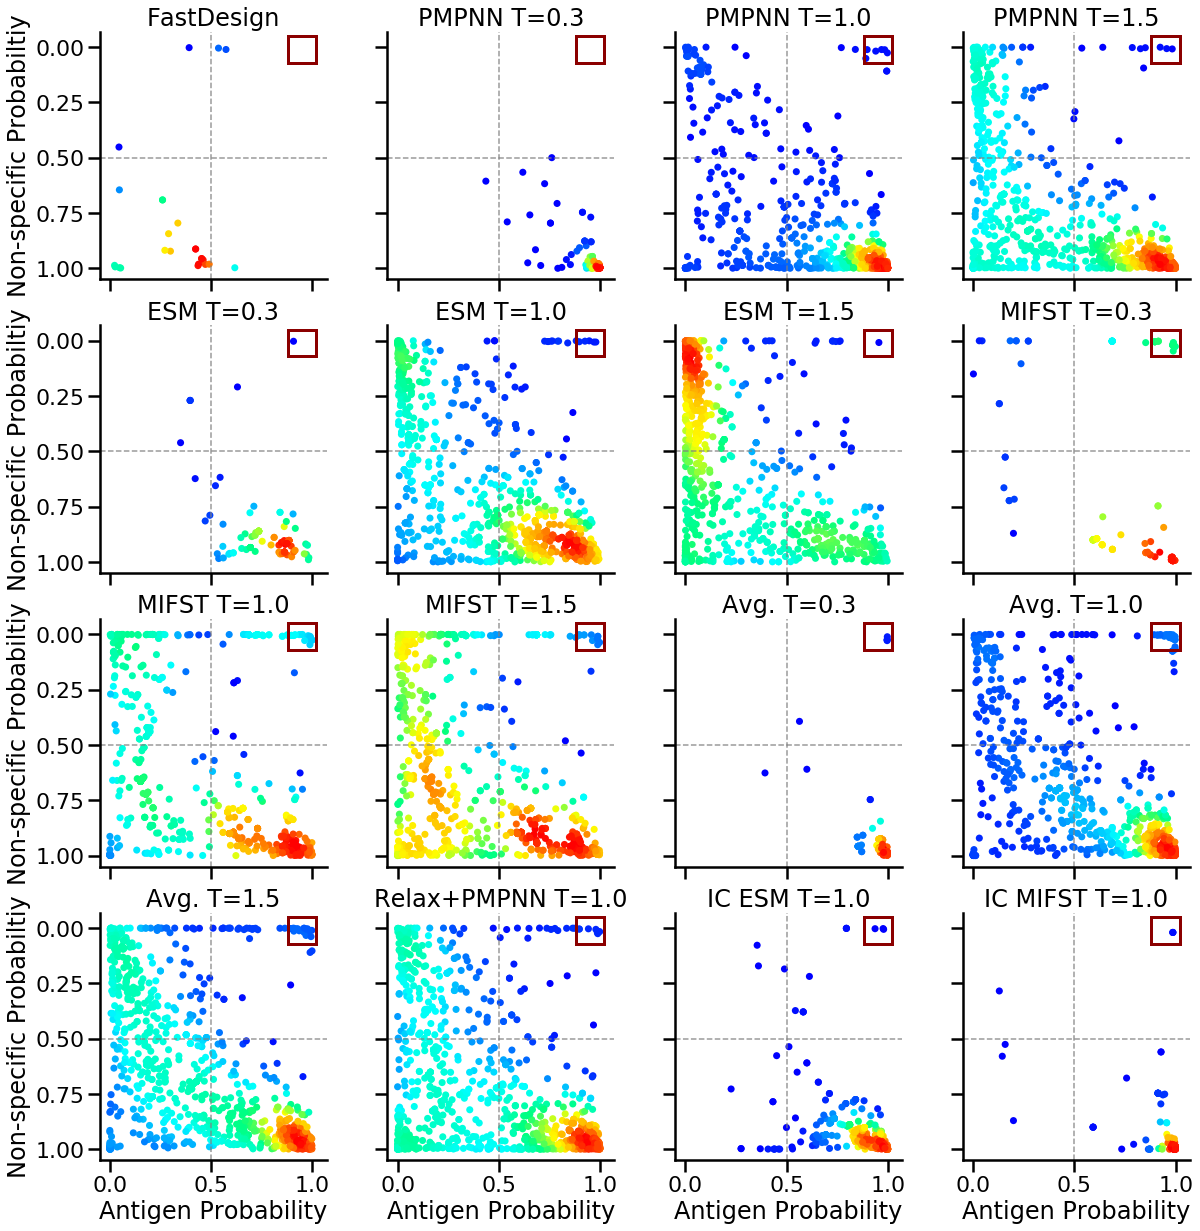

In [8]:
import matplotlib.patches as patches

colors = ["blue", 'cyan', "springgreen", "yellow", "orange", "red"]
n_bins = 100  # Increase or decrease as needed
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

subplot_height = 4.25
aspect_ratio = 1 
g = sns.FacetGrid(score_combined, col='method', col_wrap=4, height=subplot_height, aspect=aspect_ratio)

# Draw scatter plots
for ax, method in zip(g.axes.flatten(), score_combined['method'].unique()):
    df_group = score_combined[score_combined['method'] == method]
    x = df_group['ANT_score']
    y = df_group['OVA_score']
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    ax.axhline(0.5, color='gray', ls='--', lw=1.5, alpha=0.8)
    ax.axvline(0.5, color='gray', ls='--', lw=1.5, alpha=0.8)
    ax.scatter(x, y, c=z, cmap=cmap, edgecolor='', s=50)
    # Create a rectangle patch
    rectangle = patches.Rectangle((0.88, -0.05), 0.14, 0.12, linewidth=3, edgecolor='darkred', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rectangle)


for ax in g.axes.flatten():
    ax.set_ylim(1.05,-0.07)
    ax.set_xlim(-0.05,1.07)


g.set_axis_labels('Antigen Probability', 'Non-specific Probabiltiy')
g.set_titles(col_template="{col_name}")
plt.show()


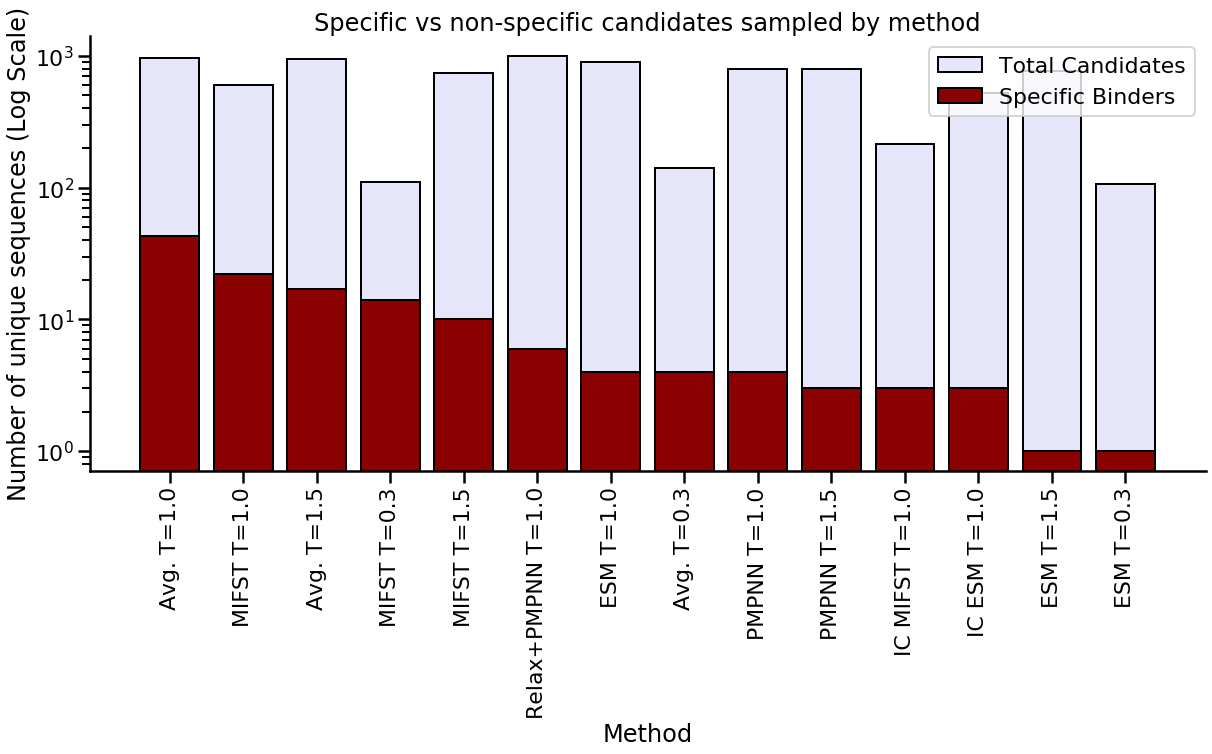

In [9]:
total_counts = score_combined.method.value_counts(sort=False)

# Count the number of rows for each method where ANT_score > 0.9
method_counts = score_combined[(score_combined.ANT_score >= 0.9) & (score_combined.OVA_score <= 0.1)].method.value_counts(sort=False)

# Align the indices of total_counts to match those of method_counts
aligned_total_counts = total_counts.reindex(method_counts.index, fill_value=0)

# Normalize method_counts by aligned_total_counts to get the fraction
fraction_counts = method_counts / aligned_total_counts

# Multiply by 100 to convert to percentage
percentage_counts = fraction_counts * 100

# Sort both method_counts and percentage_counts by method_counts in descending order
sorted_indices = method_counts.sort_values(ascending=False).index
sorted_method_counts = method_counts.reindex(sorted_indices)
sorted_percentage_counts = percentage_counts.reindex(sorted_indices)

# Reindex both counts according to this order
sorted_total_counts = aligned_total_counts.reindex(sorted_indices)
sorted_method_counts = method_counts.reindex(sorted_indices)


# Create figure and subplot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the total counts
ax.bar(sorted_total_counts.index, sorted_total_counts, label='Total Candidates', color='lavender', edgecolor='black')

# Overlay the specific binders
ax.bar(sorted_method_counts.index, sorted_method_counts, label='Specific Binders', color='darkred', edgecolor='black')

# Set log scale for y-axis
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('Method')
ax.set_ylabel('Number of unique sequences (Log Scale)')
plt.title('Specific vs non-specific candidates sampled by method')

plt.xticks(rotation=90)

legend_elements = [
    Patch(facecolor='lavender', edgecolor='black', label='Total Candidates'),
    Patch(facecolor='darkred', edgecolor='black', label='Specific Binders')
]
plt.legend(handles=legend_elements, loc='upper right')

sns.despine()

#plt.savefig('./emi/binding_stacked_barplot_log_scale.svg', dpi=300)

plt.show()

In [10]:
score_combined['avg_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_esm_mifst_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_esm_mpnn_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_mifst_mpnn_pp'] = score_combined[['mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)

## check correlation between metrics and fitness

### for antigen binding probability

In [11]:
print(spearmanr(y_pred[:,1], score_combined.total_score))
print(spearmanr(y_pred[:,1], score_combined.dG_separated))
print(spearmanr(y_pred[:,1], score_combined.delta_unsatHbonds))
print(spearmanr(y_pred[:,1], score_combined.sc_value))
print(spearmanr(y_pred[:,1], score_combined.esm_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred[:,1], score_combined.mifst_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred[:,1], score_combined.mpnn_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred[:,1], score_combined.avg_pp))
print(spearmanr(y_pred[:,1], score_combined.avg_esm_mifst_pp))
print(spearmanr(y_pred[:,1], score_combined.avg_esm_mpnn_pp))
print(spearmanr(y_pred[:,1], score_combined.avg_mifst_mpnn_pp))
print(spearmanr(y_pred[:,1], score_combined.plddt_binder))
print(spearmanr(y_pred[:,1], score_combined.binder_aligned_rmsd))
print(spearmanr(y_pred[:,1], score_combined.pae_interaction))

SpearmanrResult(correlation=-0.34587275140991836, pvalue=1.5804614949308426e-245)
SpearmanrResult(correlation=-0.23491187422600487, pvalue=1.6223108947960438e-110)
SpearmanrResult(correlation=0.01972042627219724, pvalue=0.06445553580318432)
SpearmanrResult(correlation=0.23903677212672492, pvalue=1.774311671989876e-114)
SpearmanrResult(correlation=-0.5068453557052501, pvalue=0.0)
SpearmanrResult(correlation=-0.42779651303207367, pvalue=0.0)
SpearmanrResult(correlation=-0.5252343962702674, pvalue=0.0)
SpearmanrResult(correlation=-0.6062538725220887, pvalue=0.0)
SpearmanrResult(correlation=-0.5566565960660027, pvalue=0.0)
SpearmanrResult(correlation=-0.629721228136975, pvalue=0.0)
SpearmanrResult(correlation=-0.5116265421387695, pvalue=0.0)
SpearmanrResult(correlation=0.17832139631141158, pvalue=9.923724040426442e-64)
SpearmanrResult(correlation=-0.15219563444421116, pvalue=1.0294570935054097e-46)
SpearmanrResult(correlation=-0.07967581480207991, pvalue=7.337308061376224e-14)


### for unspecific binding probability


In [12]:
print(spearmanr(y_pred_OVA[:,1], score_combined.total_score))
print(spearmanr(y_pred_OVA[:,1], score_combined.dG_separated))
print(spearmanr(y_pred_OVA[:,1], score_combined.delta_unsatHbonds))
print(spearmanr(y_pred_OVA[:,1], score_combined.sc_value))
print(spearmanr(y_pred_OVA[:,1], score_combined.esm_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred_OVA[:,1], score_combined.mifst_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred_OVA[:,1], score_combined.mpnn_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred_OVA[:,1], score_combined.avg_pp))
print(spearmanr(y_pred_OVA[:,1], score_combined.avg_esm_mifst_pp))
print(spearmanr(y_pred_OVA[:,1], score_combined.avg_esm_mpnn_pp))
print(spearmanr(y_pred_OVA[:,1], score_combined.avg_mifst_mpnn_pp))
print(spearmanr(y_pred_OVA[:,1], score_combined.plddt_binder))
print(spearmanr(y_pred_OVA[:,1], score_combined.binder_aligned_rmsd))
print(spearmanr(y_pred_OVA[:,1], score_combined.pae_interaction))

SpearmanrResult(correlation=-0.19387242374172187, pvalue=3.2796515148956403e-75)
SpearmanrResult(correlation=-0.12224499750537417, pvalue=1.2605566903451803e-30)
SpearmanrResult(correlation=0.06753455662634161, pvalue=2.3162229310384324e-10)
SpearmanrResult(correlation=0.19064877280571738, pvalue=9.547026307644842e-73)
SpearmanrResult(correlation=-0.28600620557571715, pvalue=3.831104215713585e-165)
SpearmanrResult(correlation=-0.24243667953242598, pvalue=8.43675651827371e-118)
SpearmanrResult(correlation=-0.3957699260972847, pvalue=0.0)
SpearmanrResult(correlation=-0.3758064701748853, pvalue=5.525488960199339e-293)
SpearmanrResult(correlation=-0.31734831227910854, pvalue=6.569371717634064e-205)
SpearmanrResult(correlation=-0.403754849876873, pvalue=0.0)
SpearmanrResult(correlation=-0.3365991064040942, pvalue=7.643818717359532e-232)
SpearmanrResult(correlation=0.020369960856819226, pvalue=0.056142289720237715)
SpearmanrResult(correlation=0.06177555462574117, pvalue=6.74556181677776e-09)

### for difference of both

In [13]:
diff = (score_combined.ANT_score - score_combined.OVA_score)
print(spearmanr(diff, score_combined.total_score))
print(spearmanr(diff, score_combined.dG_separated))
print(spearmanr(diff, score_combined.delta_unsatHbonds))
print(spearmanr(diff, score_combined.sc_value))
print(spearmanr(diff, score_combined.esm_pp_all_PseudoPerplexityMetric))
print(spearmanr(diff, score_combined.mifst_pp_all_PseudoPerplexityMetric))
print(spearmanr(diff, score_combined.mpnn_pp_all_PseudoPerplexityMetric))
print(spearmanr(diff, score_combined.avg_pp))
print(spearmanr(diff, score_combined.plddt_binder))
print(spearmanr(diff, score_combined.binder_aligned_rmsd))
print(spearmanr(diff, score_combined.pae_interaction))

SpearmanrResult(correlation=-0.2652602394579914, pvalue=1.7499160490653488e-141)
SpearmanrResult(correlation=-0.15423455893804075, pvalue=6.104726341779285e-48)
SpearmanrResult(correlation=-0.06914272052656475, pvalue=8.58027176031761e-11)
SpearmanrResult(correlation=0.11606227669769732, pvalue=9.453126740190795e-28)
SpearmanrResult(correlation=-0.29104494221569016, pvalue=3.326062041594647e-171)
SpearmanrResult(correlation=-0.27759572490624995, pvalue=2.658240305856362e-155)
SpearmanrResult(correlation=-0.2899462782408413, pvalue=7.148676749348936e-170)
SpearmanrResult(correlation=-0.3561260888253746, pvalue=3.284299871818356e-261)
SpearmanrResult(correlation=0.17982836212653555, pvalue=8.486707793300991e-65)
SpearmanrResult(correlation=-0.19847435936968, pvalue=8.345186654688438e-79)
SpearmanrResult(correlation=0.035864475235109106, pvalue=0.0007697192665283064)


### check ranking power for different metrics

In [14]:
for metric in ['total_score','dG_separated','sc_value','esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric', 'avg_pp','plddt_binder','binder_aligned_rmsd','pae_interaction']:#,'average_scaled']:
    if metric in ['sc_value','plddt_binder']:
        top_10 = score_combined.sort_values(metric, ascending=False)[:10].copy()
    else:
        top_10 = score_combined.sort_values(metric)[:10].copy()
    score_diff = top_10.ANT_score - top_10.OVA_score
    print(metric, '\nANT score mean', top_10.ANT_score.mean(), 'OVA score mean', top_10.OVA_score.mean())
    print('Max ANT-OVA score difference', score_diff.max())
    print('Mean ANT-OVA score difference', score_diff.mean())
    print('')

total_score 
ANT score mean 0.3972064777917053 OVA score mean 0.8255837085173294
Max ANT-OVA score difference 0.38925398609983697
Mean ANT-OVA score difference -0.42837723072562406

dG_separated 
ANT score mean 0.8144547118740049 OVA score mean 0.9477827972815096
Max ANT-OVA score difference 0.06369603550431391
Mean ANT-OVA score difference -0.13332808540750457

sc_value 
ANT score mean 0.4881034124578747 OVA score mean 0.7060207028318879
Max ANT-OVA score difference 0.3198689978583069
Mean ANT-OVA score difference -0.21791729037401333

esm_pp_all_PseudoPerplexityMetric 
ANT score mean 0.8672901572201294 OVA score mean 0.8792013965980437
Max ANT-OVA score difference 0.06467274382548871
Mean ANT-OVA score difference -0.011911239377914407

mifst_pp_all_PseudoPerplexityMetric 
ANT score mean 0.9428863678313462 OVA score mean 0.7879812492830731
Max ANT-OVA score difference 0.9662622433855943
Mean ANT-OVA score difference 0.1549051185482729

mpnn_pp_all_PseudoPerplexityMetric 
ANT score mea

### compare that to random choice

In [15]:

# Initialize variables to hold cumulative statistics
cumulative_ant_score_mean = 0
cumulative_ova_score_mean = 0
cumulative_ant_score_max = 0
cumulative_ova_score_max = 0
cumulative_ant_score_min = 0
cumulative_ova_score_min = 0
cumulative_max_diff = 0
cumulative_mean_diff = 0


# Sample 10 rows 1000 times
for i in range(1000):
    sampled_df = score_combined.sample(n=10, random_state=i)
    
    # Accumulate statistics
    cumulative_ant_score_mean += sampled_df.ANT_score.mean()
    cumulative_ova_score_mean += sampled_df.OVA_score.mean()
    cumulative_ant_score_max += sampled_df.ANT_score.max()
    cumulative_ova_score_max += sampled_df.OVA_score.max()
    cumulative_ant_score_min += sampled_df.ANT_score.min()
    cumulative_ova_score_min += sampled_df.OVA_score.min()
    cumulative_max_diff += (sampled_df.ANT_score - sampled_df.OVA_score).max()
    cumulative_mean_diff += (sampled_df.ANT_score - sampled_df.OVA_score).mean()

# Calculate the mean of the cumulative statistics
final_mean_ant_score_mean = cumulative_ant_score_mean / 1000
final_mean_ova_score_mean = cumulative_ova_score_mean / 1000
final_mean_ant_score_max = cumulative_ant_score_max / 1000
final_mean_ova_score_max = cumulative_ova_score_max / 1000
final_mean_ant_score_min = cumulative_ant_score_min / 1000
final_mean_ova_score_min = cumulative_ova_score_min / 1000
final_mean_max_diff = cumulative_max_diff / 1000
final_mean_diff = cumulative_mean_diff / 1000


# Print the final results
print('Mean of ANT score mean:', final_mean_ant_score_mean)
print('Mean of OVA score mean:', final_mean_ova_score_mean)
print('Mean of ANT score max:', final_mean_ant_score_max)
print('Mean of OVA score max:', final_mean_ova_score_max)
print('Mean of ANT score min:', final_mean_ant_score_min)
print('Mean of OVA score min:', final_mean_ova_score_min)
print('Mean of Max ANT-OVA score difference:', final_mean_max_diff)
print('Mean of ANT-OVA score difference:', final_mean_diff)



Mean of ANT score mean: 0.5698277935320356
Mean of OVA score mean: 0.7303061338181571
Mean of ANT score max: 0.9819727512006791
Mean of OVA score max: 0.9944339963328461
Mean of ANT score min: 0.04286597963666492
Mean of OVA score min: 0.12097296066526636
Mean of Max ANT-OVA score difference: 0.3202145583046577
Mean of ANT-OVA score difference: -0.1604783402861214


# Herceptin

In [16]:
score_combined = pd.read_csv('herceptin/herceptin_designs.csv', index_col=0)
score_combined.head()

,SCORE:_score,total_score,complex_normalized,dG_cross,dG_cross/dSASAx100,dG_separated,dG_separated/dSASAx100,dSASA_hphobic,dSASA_int,dSASA_polar,...,pae_binder,pae_interaction,pae_target,plddt_binder,plddt_target,plddt_total,target_aligned_rmsd,time,description_af2,n_mutations
0,SCORE:,-857.208,-2.662,0.0,0.0,-60.167,-2.665,1440.859,2257.235,816.376,...,6.820,18.475,16.640,85.767,73.112,77.789,3.744,28.107,herceptin_her2_relax_best_0001_af2pred,6
1,SCORE:,-856.997,-2.661,0.0,0.0,-61.307,-2.607,1459.969,2351.848,891.880,...,6.803,18.435,17.763,85.429,67.333,74.020,5.506,28.467,herceptin_her2_relax_best_0002_af2pred,6
2,SCORE:,-854.055,-2.652,0.0,0.0,-61.980,-2.552,1494.480,2428.760,934.280,...,6.785,18.789,16.945,85.804,73.175,77.842,5.405,29.110,herceptin_her2_relax_best_0003_af2pred,6
3,SCORE:,-858.415,-2.666,0.0,0.0,-62.030,-2.555,1533.547,2427.608,894.061,...,6.929,19.090,17.148,85.393,72.838,77.478,6.880,29.107,herceptin_her2_relax_best_0004_af2pred,6
4,SCORE:,-854.946,-2.655,0.0,0.0,-65.518,-2.830,1399.007,2315.208,916.202,...,6.818,18.951,17.070,85.440,73.021,77.611,5.978,28.559,herceptin_her2_relax_best_0005_af2pred,7


## predict binding probability

In [17]:
herceptin_model = load('./herceptin/lda_herceptin.joblib')
score_combined['encoded'] = one_hot_encode_sequences(score_combined, 'sequence')
score_combined['Flattened_Encoded'] = score_combined['encoded'].apply(lambda x: x.flatten())
X = np.stack(score_combined['Flattened_Encoded'].values)

y_pred = herceptin_model.predict_proba(X)
score_combined['ANT_score'] = y_pred[:,1]

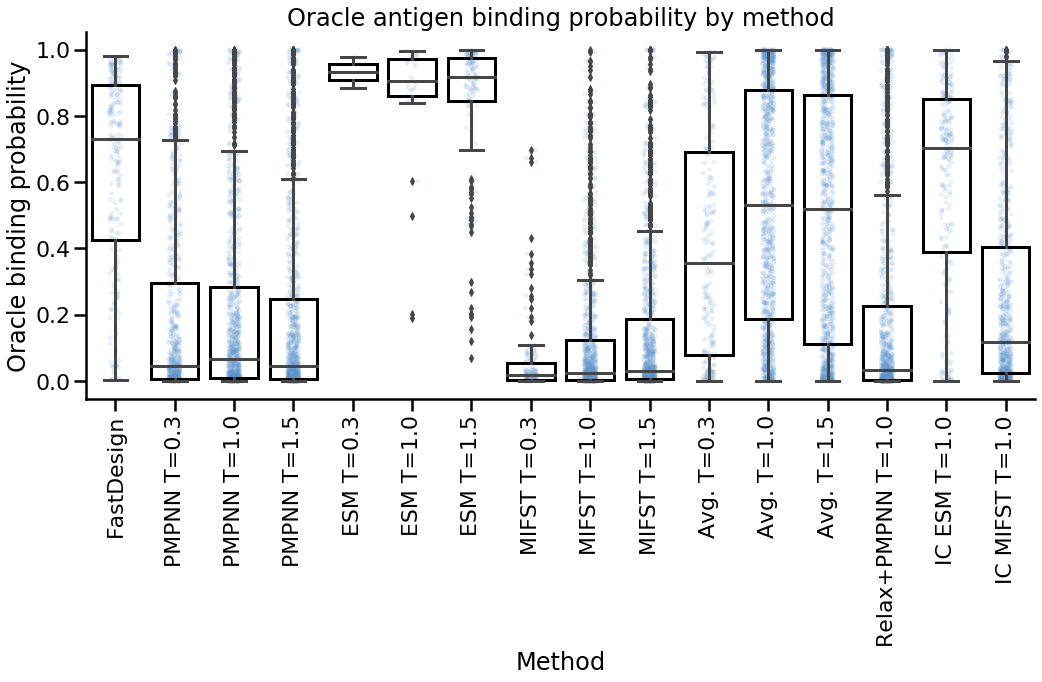

In [18]:
ax = sns.boxplot(y='ANT_score', x='method', data=score_combined, 
                 boxprops=dict(facecolor='none', edgecolor='k'))
ax = sns.stripplot(y='ANT_score', x='method', data=score_combined, 
                   color='dodgerblue', alpha=0.1, edgecolor='darkgrey', size=4, linewidth=1, zorder=0)


#plt.ylim(-2200, -1400)
plt.title('Oracle antigen binding probability by method')
plt.xticks(rotation=90)
plt.ylabel('Oracle binding probability')
plt.xlabel('Method')
sns.despine(trim=False, right=True)
plt.tight_layout()
#plt.savefig('./herceptin/binding_boxplot.png', dpi=400)

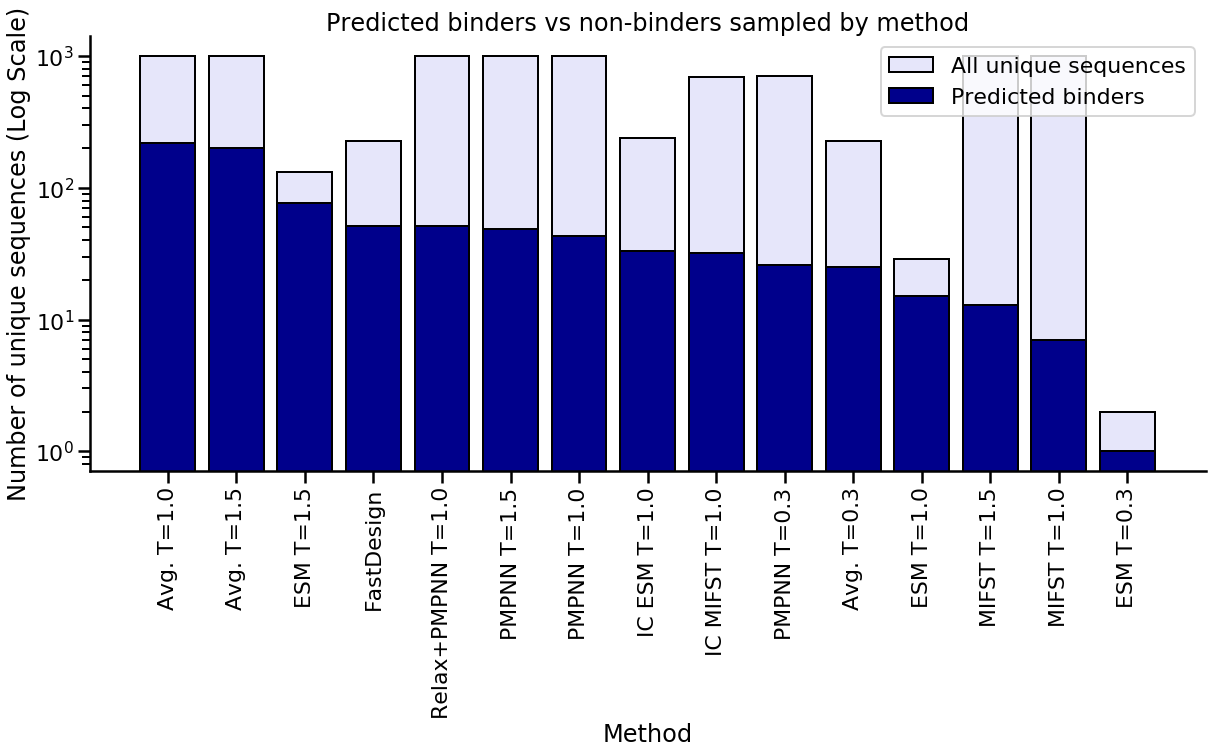

In [19]:
## Count the total number of rows for each method
total_counts = score_combined.method.value_counts(sort=False)

# Count the number of rows for each method where ANT_score > 0.9
method_counts = score_combined[score_combined.ANT_score > 0.9].method.value_counts(sort=False)

# Align the indices of total_counts to match those of method_counts
aligned_total_counts = total_counts.reindex(method_counts.index, fill_value=0)

# Normalize method_counts by aligned_total_counts to get the fraction
fraction_counts = method_counts / aligned_total_counts

# Multiply by 100 to convert to percentage
percentage_counts = fraction_counts * 100

# Sort both method_counts and percentage_counts by method_counts in descending order
sorted_indices = method_counts.sort_values(ascending=False).index
sorted_method_counts = method_counts.reindex(sorted_indices)
sorted_percentage_counts = percentage_counts.reindex(sorted_indices)

# Reindex both counts according to this order
sorted_total_counts = aligned_total_counts.reindex(sorted_indices)
sorted_method_counts = method_counts.reindex(sorted_indices)


fig, ax = plt.subplots(figsize=(20, 8))

# Plot the total counts
ax.bar(sorted_total_counts.index, sorted_total_counts, label='Total Candidates', color='lavender', edgecolor='black')

# Overlay the specific binders
ax.bar(sorted_method_counts.index, sorted_method_counts, label='Specific Binders', color='darkblue', edgecolor='black')

# Set log scale for y-axis
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('Method')
ax.set_ylabel('Number of unique sequences (Log Scale)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.title('Predicted binders vs non-binders sampled by method')

legend_elements = [Patch(facecolor='lavender', edgecolor='black', label='All unique sequences'),
                   Patch(facecolor='darkblue', edgecolor='black', label='Predicted binders')]

plt.legend(handles=legend_elements, loc='upper right')


sns.despine()

#plt.savefig('./herceptin/binding_stacked_barplot_log_scale.svg', dpi=300)

plt.show()

In [20]:
score_combined['avg_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_esm_mifst_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_esm_mpnn_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_mifst_mpnn_pp'] = score_combined[['mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)

## check correlation of metrics to predicted binding

In [21]:
print(spearmanr(y_pred[:,1], score_combined.total_score))
print(spearmanr(y_pred[:,1], score_combined.dG_separated))
print(spearmanr(y_pred[:,1], score_combined.delta_unsatHbonds))
print(spearmanr(y_pred[:,1], score_combined.sc_value))
print(spearmanr(y_pred[:,1], score_combined.esm_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred[:,1], score_combined.mifst_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred[:,1], score_combined.mpnn_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred[:,1], score_combined.avg_pp))
print(spearmanr(y_pred[:,1], score_combined.plddt_binder))
print(spearmanr(y_pred[:,1], score_combined.binder_aligned_rmsd))
print(spearmanr(y_pred[:,1], score_combined.pae_interaction))

SpearmanrResult(correlation=-0.031286455301317524, pvalue=0.0023876914460524423)
SpearmanrResult(correlation=-0.11941382937030981, pvalue=2.8590934868903223e-31)
SpearmanrResult(correlation=0.16085603350401728, pvalue=1.209595958019464e-55)
SpearmanrResult(correlation=-0.09402103978047309, pvalue=5.941400684522273e-20)
SpearmanrResult(correlation=-0.05177194344937085, pvalue=4.954882798926467e-07)
SpearmanrResult(correlation=0.12110410071320782, pvalue=4.04033347495359e-32)
SpearmanrResult(correlation=0.06971751440263767, pvalue=1.2473793631650642e-11)
SpearmanrResult(correlation=-0.0516731928674895, pvalue=5.209051212934007e-07)
SpearmanrResult(correlation=-0.2732656587651288, pvalue=5.3189649472795425e-161)
SpearmanrResult(correlation=0.28121687100142034, pvalue=8.790093976353216e-171)
SpearmanrResult(correlation=-0.30795551253143355, pvalue=4.074564327993969e-206)


## check ranking power of different metrics

In [22]:
for metric in ['total_score','dG_separated','sc_value','esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric','avg_pp','plddt_binder','binder_aligned_rmsd','pae_interaction']:
    if metric in ['sc_value','plddt_binder']:
        top_10 = score_combined.sort_values(metric, ascending=False)[:10].copy()
    else:
        top_10 = score_combined.sort_values(metric)[:10].copy()
    print(metric)
    print('Mean prob of Top 10:', top_10.ANT_score.mean())
    print('Median prob of Top 10:', top_10.ANT_score.median())
    print('Max prob of Top 10:', top_10.ANT_score.max())
    print()

total_score
Mean prob of Top 10: 0.7027558019307742
Median prob of Top 10: 0.8321244414588237
Max prob of Top 10: 0.9243663131627994

dG_separated
Mean prob of Top 10: 0.663409162495888
Median prob of Top 10: 0.8343090072427999
Max prob of Top 10: 0.9802925111865876

sc_value
Mean prob of Top 10: 0.40326856498943214
Median prob of Top 10: 0.43667122808968134
Max prob of Top 10: 0.8950368995118947

esm_pp_all_PseudoPerplexityMetric
Mean prob of Top 10: 0.3461390927310229
Median prob of Top 10: 0.2657640596561324
Max prob of Top 10: 0.9709036225652338

mifst_pp_all_PseudoPerplexityMetric
Mean prob of Top 10: 0.2931779907380183
Median prob of Top 10: 0.28039333364367924
Max prob of Top 10: 0.4588542662447227

mpnn_pp_all_PseudoPerplexityMetric
Mean prob of Top 10: 0.20838881379526414
Median prob of Top 10: 0.007884539896149059
Max prob of Top 10: 0.8633828674542068

avg_pp
Mean prob of Top 10: 0.3461390927310229
Median prob of Top 10: 0.2657640596561324
Max prob of Top 10: 0.9709036225652

## compare to random choice

In [23]:

# Initialize variables to hold cumulative statistics
cumulative_ant_score_mean = 0
cumulative_ova_score_mean = 0
cumulative_ant_score_max = 0
cumulative_ova_score_max = 0
cumulative_ant_score_min = 0
cumulative_ova_score_min = 0



# Sample 10 rows 1000 times
for i in range(1000):
    sampled_df = score_combined.sample(n=10, random_state=i)
    
    # Accumulate statistics
    cumulative_ant_score_mean += sampled_df.ANT_score.mean()
    cumulative_ant_score_max += sampled_df.ANT_score.max()
    cumulative_ant_score_min += sampled_df.ANT_score.min()

# Calculate the mean of the cumulative statistics
final_mean_ant_score_mean = cumulative_ant_score_mean / 1000
final_mean_ant_score_max = cumulative_ant_score_max / 1000
final_mean_ant_score_min = cumulative_ant_score_min / 1000

# Print the final results
print('Mean of ANT score mean:', final_mean_ant_score_mean)
print('Mean of ANT score max:', final_mean_ant_score_max)
print('Mean of ANT score min:', final_mean_ant_score_min)


Mean of ANT score mean: 0.2855008480773248
Mean of ANT score max: 0.8707261697341154
Mean of ANT score min: 0.003229754488811123


# GB1

In [24]:
score_combined = pd.read_csv('gb1/gb1_designs.csv', index_col=0)
score_combined.head()

,SCORE:_score,total_score,complex_normalized,dG_cross,dG_cross/dSASAx100,dG_separated,dG_separated/dSASAx100,dSASA_hphobic,dSASA_int,dSASA_polar,...,binder_aligned_rmsd,pae_binder,pae_interaction,pae_target,plddt_binder,plddt_target,plddt_total,target_aligned_rmsd,time,description_af2
0,SCORE:,-778.570,-2.972,-50.466,-3.212,-43.526,-2.770,833.748,1571.393,737.644,...,0.634,4.938,11.953,13.861,88.372,90.086,89.720,8.606,21.103,gb1_IgG1FC_relax_best_0001_af2pred
1,CORE:,-771.852,-2.946,-49.671,-3.125,-42.744,-2.689,846.352,1589.353,743.002,...,0.722,5.408,12.334,13.970,86.834,89.399,88.851,9.434,20.684,gb1_IgG1FC_relax_best_0002_af2pred
2,SCORE:,-778.996,-2.973,-51.969,-3.190,-44.942,-2.758,867.091,1629.332,762.241,...,0.705,5.403,12.293,13.976,86.711,88.529,88.141,10.846,20.659,gb1_IgG1FC_relax_best_0013_af2pred
3,SCORE:,-778.655,-2.972,-51.565,-3.214,-44.358,-2.764,867.628,1604.568,736.940,...,0.635,4.877,12.082,14.015,88.646,87.114,87.442,7.265,20.545,gb1_IgG1FC_relax_best_0132_af2pred
4,SCORE:,-767.049,-2.928,-50.952,-3.131,-43.959,-2.701,849.138,1627.330,778.192,...,0.721,5.427,12.319,13.975,86.738,89.235,88.701,10.366,21.056,gb1_IgG1FC_relax_best_0405_af2pred


## predict fitness

In [25]:
gb1_model = load('./gb1/gb1_ridge.joblib')
score_combined['encoded'] = one_hot_encode_sequences(score_combined, 'sequence')
score_combined['Flattened_Encoded'] = score_combined['encoded'].apply(lambda x: x.flatten())
X = np.stack(score_combined['Flattened_Encoded'].values)

y_pred = gb1_model.predict(X)
score_combined['Fitness'] = y_pred

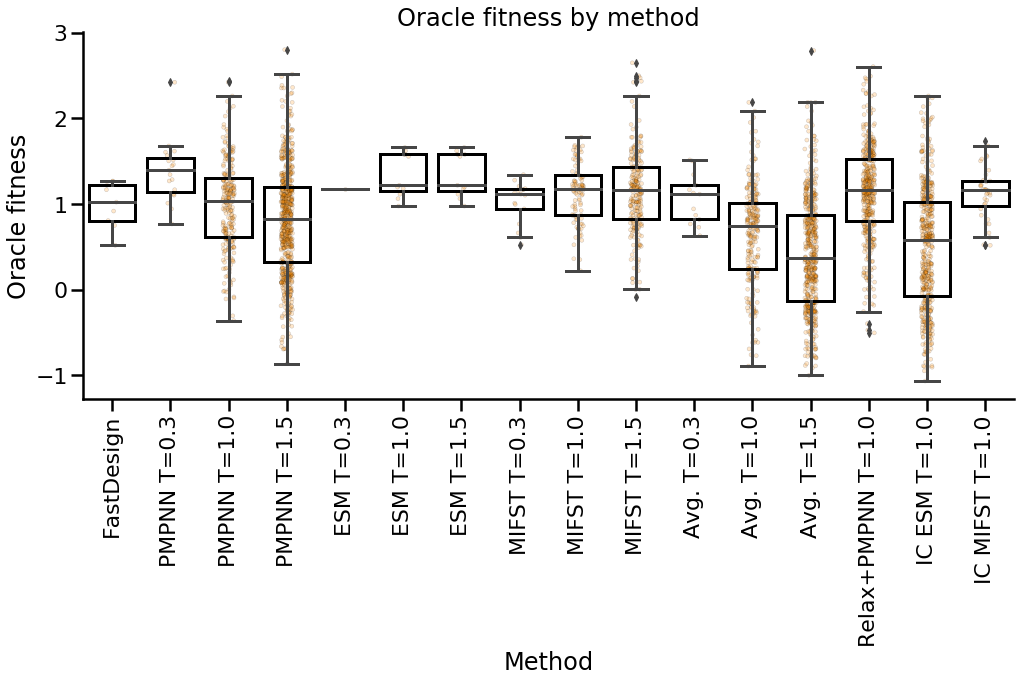

In [26]:
ax = sns.boxplot(y='Fitness', x='method', data=score_combined, 
                 boxprops=dict(facecolor='none', edgecolor='k'))
ax = sns.stripplot(y='Fitness', x='method', data=score_combined, 
                   color='darkorange', alpha=0.2, edgecolor='k', size=4, linewidth=0.5, zorder=0)


#plt.ylim(-2200, -1400)
plt.title('Oracle fitness by method')
plt.xticks(rotation=90)
plt.ylabel('Oracle fitness')
plt.xlabel('Method')
sns.despine(trim=False, right=True)
plt.tight_layout()
#plt.savefig('./gb1/binding_boxplot.png', dpi=400)

/home/iwe3/anaconda3/envs/PyRosetta.notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


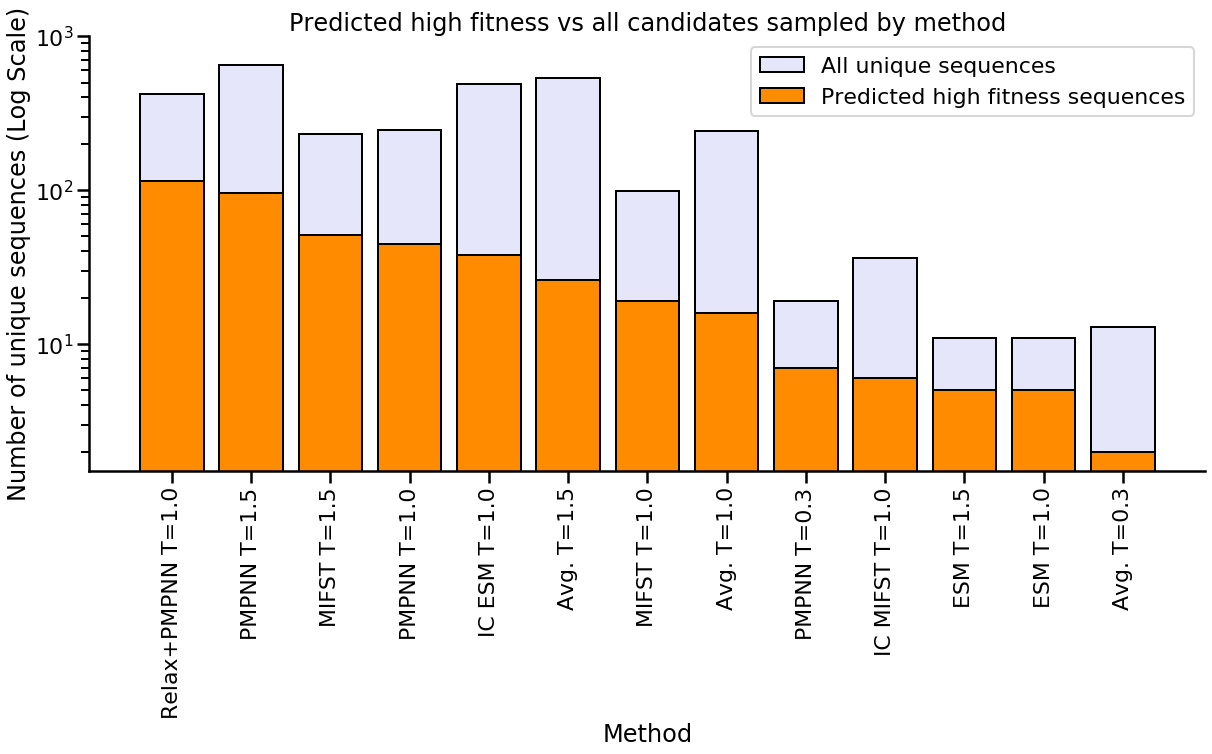

In [27]:
total_counts = score_combined.method.value_counts(sort=False)

# Count the number of rows for each method where ANT_score > 0.9
method_counts = score_combined[(score_combined.Fitness > 1.5)].method.value_counts(sort=False)

# Align the indices of total_counts to match those of method_counts
aligned_total_counts = total_counts.reindex(method_counts.index, fill_value=0)

# Normalize method_counts by aligned_total_counts to get the fraction
fraction_counts = method_counts / aligned_total_counts

# Multiply by 100 to convert to percentage
percentage_counts = fraction_counts * 100

# Sort both method_counts and percentage_counts by method_counts in descending order
sorted_indices = method_counts.sort_values(ascending=False).index
sorted_percentage_counts = percentage_counts.reindex(sorted_indices)
# Reindex both counts according to sorted_indices
sorted_total_counts = aligned_total_counts.reindex(sorted_indices)
sorted_method_counts = method_counts.reindex(sorted_indices)

# Create figure and subplot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the total counts
ax.bar(sorted_total_counts.index, sorted_total_counts, label='Total Candidates', color='lavender', edgecolor='black')

# Overlay the specific binders
ax.bar(sorted_method_counts.index, sorted_method_counts, label='Specific Binders', color='darkorange', edgecolor='black')

# Set log scale for y-axis
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('Method')
ax.set_ylabel('Number of unique sequences (Log Scale)')
plt.title('Predicted high fitness vs all candidates sampled by method')

plt.ylim(0, 1000)
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

legend_elements = [Patch(facecolor='lavender', edgecolor='black', label='All unique sequences'),
                   Patch(facecolor='darkorange', edgecolor='black', label='Predicted high fitness sequences')]


plt.legend(handles=legend_elements, loc='upper right')



sns.despine()

#plt.savefig('./gb1/binding_stacked_barplot_log_scale.svg', dpi=300)

plt.show()

## check correlation of metrics with fitness

In [28]:
print(spearmanr(y_pred, score_combined.total_score))
print(spearmanr(y_pred, score_combined.dG_separated))
print(spearmanr(y_pred, score_combined.delta_unsatHbonds))
print(spearmanr(y_pred, score_combined.sc_value))
print(spearmanr(y_pred, score_combined.esm_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred, score_combined.mifst_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred, score_combined.mpnn_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred, score_combined.plddt_binder))
print(spearmanr(y_pred, score_combined.binder_aligned_rmsd))
print(spearmanr(y_pred, score_combined.pae_interaction))


SpearmanrResult(correlation=-0.5478481357029285, pvalue=1.009757811627893e-236)
SpearmanrResult(correlation=-0.3830486814527072, pvalue=2.2315530313152023e-106)
SpearmanrResult(correlation=-0.10588153514842683, pvalue=5.238167923824456e-09)
SpearmanrResult(correlation=-0.023541883326329473, pvalue=0.19536300052044653)
SpearmanrResult(correlation=0.0742824969099359, pvalue=4.297910188689383e-05)
SpearmanrResult(correlation=-0.6032518451344276, pvalue=1.5839695795889044e-299)
SpearmanrResult(correlation=-0.41706890585620343, pvalue=1.0364365770506687e-127)
SpearmanrResult(correlation=0.16138051620184157, pvalue=4.115767913683956e-19)
SpearmanrResult(correlation=-0.1724205742994163, pvalue=1.2480387713088204e-21)
SpearmanrResult(correlation=0.04385017640903887, pvalue=0.01583393957359294)


## check ranking power of different metrics

In [29]:
score_combined['avg_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_esm_mifst_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_esm_mpnn_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_mifst_mpnn_pp'] = score_combined[['mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)

In [30]:
for metric in ['total_score','dG_separated','sc_value','esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric','avg_pp','plddt_binder','binder_aligned_rmsd','pae_interaction']:
    if metric in ['sc_value','plddt_binder']:
        top_10 = score_combined.sort_values(metric, ascending=False)[:10].copy()
    else:
        top_10 = score_combined.sort_values(metric)[:10].copy()
    print(metric)
    print('Mean Fitness of Top 10:', top_10.Fitness.mean())
    print('Median Fitness of Top 10:', top_10.Fitness.median())
    print('Max Fitness of Top 10:', top_10.Fitness.max())
    print()

total_score
Mean Fitness of Top 10: 1.2161594115576224
Median Fitness of Top 10: 1.2197405176555272
Max Fitness of Top 10: 1.5839298069116565

dG_separated
Mean Fitness of Top 10: 0.7411118128472094
Median Fitness of Top 10: 0.7065072836801509
Max Fitness of Top 10: 2.4746787272997364

sc_value
Mean Fitness of Top 10: 0.6775181404979846
Median Fitness of Top 10: 0.5143846021502324
Max Fitness of Top 10: 1.7287802203256306

esm_pp_all_PseudoPerplexityMetric
Mean Fitness of Top 10: 1.0773497377360983
Median Fitness of Top 10: 1.068938890630143
Max Fitness of Top 10: 2.362319798405336

mifst_pp_all_PseudoPerplexityMetric
Mean Fitness of Top 10: 1.1666722639475702
Median Fitness of Top 10: 1.1280248699599988
Max Fitness of Top 10: 1.5933585064614322

mpnn_pp_all_PseudoPerplexityMetric
Mean Fitness of Top 10: 1.3256330402994527
Median Fitness of Top 10: 1.3760291206494055
Max Fitness of Top 10: 1.6305098603275887

avg_pp
Mean Fitness of Top 10: 1.154539314899764
Median Fitness of Top 10: 1.

### compare to random choice

In [31]:
# Initialize variables to hold cumulative statistics
cumulative_ant_score_mean = 0
cumulative_ova_score_mean = 0
cumulative_ant_score_max = 0
cumulative_ova_score_max = 0
cumulative_ant_score_min = 0
cumulative_ova_score_min = 0
cumulative_max_diff = 0

# Sample 10 rows 1000 times
for i in range(1000):
    sampled_df = score_combined.sample(n=10, random_state=i)
    
    # Accumulate statistics
    cumulative_ant_score_mean += sampled_df.Fitness.mean()
    cumulative_ant_score_max += sampled_df.Fitness.max()
    cumulative_ant_score_min += sampled_df.Fitness.min()

# Calculate the mean of the cumulative statistics
final_mean_ant_score_mean = cumulative_ant_score_mean / 1000
final_mean_ant_score_max = cumulative_ant_score_max / 1000
final_mean_ant_score_min = cumulative_ant_score_min / 1000

# Print the final results
print('Mean of Fitness score mean:', final_mean_ant_score_mean)
print('Mean of Fitness score max:', final_mean_ant_score_max)
print('Mean of Fitness score min:', final_mean_ant_score_min)


Mean of Fitness score mean: 0.7976999688026601
Mean of Fitness score max: 1.73827182953866
Mean of Fitness score min: -0.24042315873117093


# GFP

In [32]:
score_combined = pd.read_csv('gfp/gfp_designs.csv', index_col=0)
score_combined.head()

,SCORE:_score,total_score,dslf_fa13,esm_pp_all_PseudoPerplexityMetric,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,...,pae_binder,pae_interaction,pae_target,plddt_binder,plddt_target,plddt_total,target_aligned_rmsd,time,description_af2,n_mutations
0,SCORE:,-741.138,0.0,16.598,-1332.567,32.803,112.986,232.489,-515.414,-83.020,...,24.063,NaN,NaN,27.008,NaN,27.008,26.161,16.382,avGFP_F64L_relax_best_0003_af2pred,3
1,SCORE:,-744.623,0.0,17.045,-1344.092,32.061,114.581,232.972,-512.150,-85.024,...,24.395,NaN,NaN,26.418,NaN,26.418,36.751,16.241,avGFP_F64L_relax_best_0004_af2pred,2
2,SCORE:,-751.578,0.0,16.730,-1348.870,33.186,116.868,223.275,-505.055,-84.495,...,22.722,NaN,NaN,32.364,NaN,32.364,78.942,16.314,avGFP_F64L_relax_best_0005_af2pred,4
3,SCORE:,-741.764,0.0,17.081,-1353.278,37.795,117.787,228.068,-499.521,-86.130,...,21.775,NaN,NaN,35.779,NaN,35.779,63.849,17.221,avGFP_F64L_relax_best_0006_af2pred,3
4,SCORE:,-757.558,0.0,16.911,-1357.439,33.484,114.226,230.075,-515.976,-86.334,...,19.615,NaN,NaN,42.140,NaN,42.140,34.133,17.285,avGFP_F64L_relax_best_0007_af2pred,4


## predict fitness

In [33]:
model_gfp = load('gfp/gfp_ridge.joblib')
# one hot encode
score_combined['encoded'] = one_hot_encode_sequences(score_combined, 'sequence')
score_combined['Flattened_Encoded'] = score_combined['encoded'].apply(lambda x: x.flatten())
X = np.stack(score_combined['Flattened_Encoded'].values)
y_pred = model_gfp.predict(X)
score_combined['oracle_score'] = y_pred

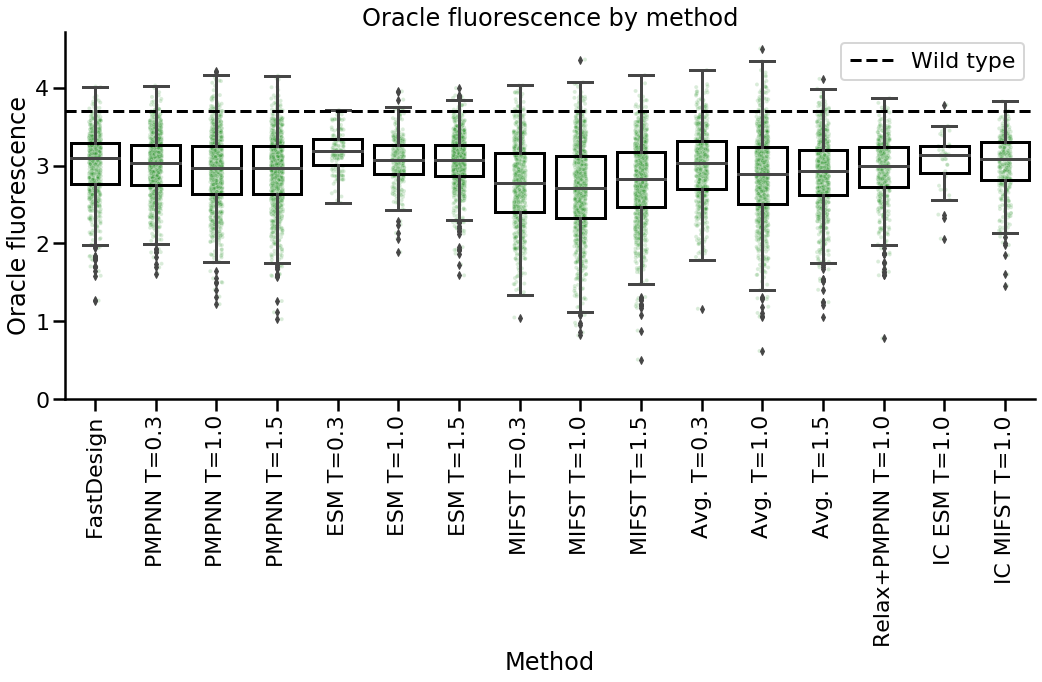

In [34]:
ax = sns.boxplot(y='oracle_score', x='method', data=score_combined, 
                 boxprops=dict(facecolor='none', edgecolor='k'))
ax = sns.stripplot(y='oracle_score', x='method', data=score_combined, 
                   color='green', alpha=0.15, edgecolor='white', size=4, linewidth=1, zorder=0)

plt.axhline(y=3.7, color='k', linestyle='--', label='Wild type')

# Label the line
#plt.text(x=5, y=4, s=' Wild Type', color='k', va='bottom', ha='right')

plt.legend()

plt.ylim(bottom=0)
plt.title('Oracle fluorescence by method')
plt.xticks(rotation=90)
plt.ylabel('Oracle fluorescence')
plt.xlabel('Method')
sns.despine(trim=False, right=True)
plt.tight_layout()
#plt.savefig('./gfp/binding_boxplot.png', dpi=400)

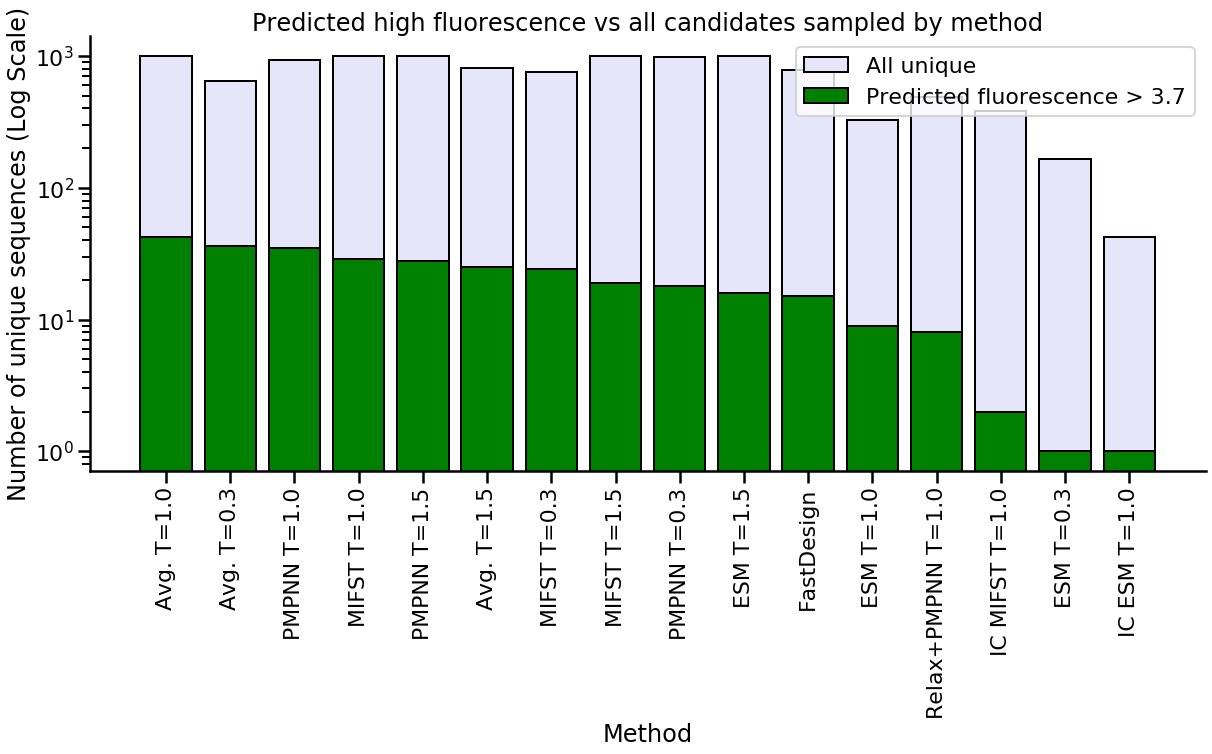

In [35]:
total_counts = score_combined.method.value_counts(sort=False)

# Count the number of rows for each method where ANT_score > 0.9
method_counts = score_combined[(score_combined.oracle_score > 3.7)].method.value_counts(sort=False)

# Align the indices of total_counts to match those of method_counts
aligned_total_counts = total_counts.reindex(method_counts.index, fill_value=0)

# Normalize method_counts by aligned_total_counts to get the fraction
fraction_counts = method_counts / aligned_total_counts

# Multiply by 100 to convert to percentage
percentage_counts = fraction_counts * 100

# Sort both method_counts and percentage_counts by method_counts in descending order
sorted_indices = method_counts.sort_values(ascending=False).index
sorted_method_counts = method_counts.reindex(sorted_indices)
sorted_percentage_counts = percentage_counts.reindex(sorted_indices)
# Reindex both counts according to sorted_indices
sorted_total_counts = aligned_total_counts.reindex(sorted_indices)
sorted_method_counts = method_counts.reindex(sorted_indices)

# Create figure and subplot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the total counts
ax.bar(sorted_total_counts.index, sorted_total_counts, label='Total Candidates', color='lavender', edgecolor='black')

# Overlay the specific binders
ax.bar(sorted_method_counts.index, sorted_method_counts, label='Predicted fluorescence > 3.7', color='green', edgecolor='black')

# Set log scale for y-axis
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('Method')
ax.set_ylabel('Number of unique sequences (Log Scale)')
plt.title('Predicted high fluorescence vs all candidates sampled by method')

#plt.ylim(0, 1000)
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)


legend_elements = [Patch(facecolor='lavender', edgecolor='black', label='All unique'),
                   Patch(facecolor='green', edgecolor='black', label='Predicted fluorescence > 3.7')]

plt.legend(handles=legend_elements, loc='upper right')



sns.despine()

#plt.savefig('./gfp/binding_stacked_barplot_log_scale.svg', dpi=300)

plt.show()

### check correlation of metrics to predicted fitness

In [36]:
score_combined['avg_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_esm_mifst_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_esm_mpnn_pp'] = score_combined[['esm_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)
score_combined['avg_mifst_mpnn_pp'] = score_combined[['mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric']].mean(axis=1)

In [37]:
print(spearmanr(y_pred, score_combined.total_score))
print(spearmanr(y_pred, score_combined.esm_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred, score_combined.mifst_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred, score_combined.mpnn_pp_all_PseudoPerplexityMetric))
print(spearmanr(y_pred, score_combined.avg_pp))
print(spearmanr(y_pred, score_combined.plddt_binder))
print(spearmanr(y_pred, score_combined.binder_aligned_rmsd))


SpearmanrResult(correlation=-0.2666449080513814, pvalue=1.916395580840366e-183)
SpearmanrResult(correlation=0.026363006871370043, pvalue=0.005041984836447082)
SpearmanrResult(correlation=0.02456630931278565, pvalue=0.008970999552628511)
SpearmanrResult(correlation=-0.02707157421117886, pvalue=0.003980038524102497)
SpearmanrResult(correlation=0.005454704368559541, pvalue=0.5618186457929528)
SpearmanrResult(correlation=-0.04091410409393498, pvalue=1.3412536556229788e-05)
SpearmanrResult(correlation=0.07408267551301895, pvalue=3.023182959723963e-15)


### check ranking power of different metrics

In [38]:
for metric in ['total_score','esm_pp_all_PseudoPerplexityMetric','mifst_pp_all_PseudoPerplexityMetric','mpnn_pp_all_PseudoPerplexityMetric','avg_pp','plddt_binder','binder_aligned_rmsd']:

    if metric in ['plddt_binder']:
        top_10 = score_combined.sort_values(metric, ascending=False)[:10].copy()
    else:
        top_10 = score_combined.sort_values(metric)[:10].copy()
    print(metric)
    print('Mean Fitness of Top 10:', top_10.oracle_score.mean())
    print('Median Fitness of Top 10:', top_10.oracle_score.median())
    print('Max Fitness of Top 10:', top_10.oracle_score.max())
    print()

total_score
Mean Fitness of Top 10: 2.7888414852821377
Median Fitness of Top 10: 2.851849558123675
Max Fitness of Top 10: 3.8759906825418042

esm_pp_all_PseudoPerplexityMetric
Mean Fitness of Top 10: 3.366043276092204
Median Fitness of Top 10: 3.3282890323881915
Max Fitness of Top 10: 3.7128341805420106

mifst_pp_all_PseudoPerplexityMetric
Mean Fitness of Top 10: 2.582082818633064
Median Fitness of Top 10: 2.5945253550555556
Max Fitness of Top 10: 3.138989127709948

mpnn_pp_all_PseudoPerplexityMetric
Mean Fitness of Top 10: 3.0611216278672897
Median Fitness of Top 10: 3.09352651105128
Max Fitness of Top 10: 3.4367778080741616

avg_pp
Mean Fitness of Top 10: 2.8622512986690523
Median Fitness of Top 10: 2.8700913454038677
Max Fitness of Top 10: 3.595496086647053

plddt_binder
Mean Fitness of Top 10: 2.9428702366509443
Median Fitness of Top 10: 2.6652322197598473
Max Fitness of Top 10: 3.94123554709266

binder_aligned_rmsd
Mean Fitness of Top 10: 2.3988425189229665
Median Fitness of Top 1

### compare to random choice

In [39]:
# Initialize variables to hold cumulative statistics
cumulative_ant_score_mean = 0
cumulative_ova_score_mean = 0
cumulative_ant_score_max = 0
cumulative_ova_score_max = 0
cumulative_ant_score_min = 0
cumulative_ova_score_min = 0
cumulative_max_diff = 0

# Sample 10 rows 1000 times
for i in range(1000):
    sampled_df = score_combined.sample(n=10, random_state=i)
    
    # Accumulate statistics
    cumulative_ant_score_mean += sampled_df.oracle_score.mean()
    cumulative_ant_score_max += sampled_df.oracle_score.max()
    cumulative_ant_score_min += sampled_df.oracle_score.min()

# Calculate the mean of the cumulative statistics
final_mean_ant_score_mean = cumulative_ant_score_mean / 1000
final_mean_ant_score_max = cumulative_ant_score_max / 1000
final_mean_ant_score_min = cumulative_ant_score_min / 1000

# Print the final results
print('Mean of Fluorescence score mean:', final_mean_ant_score_mean)
print('Mean of Fluorescence score max:', final_mean_ant_score_max)
print('Mean of Fluorescence score min:', final_mean_ant_score_min)

Mean of Fluorescence score mean: 2.9128012116746325
Mean of Fluorescence score max: 3.549946146858868
Mean of Fluorescence score min: 2.1235508192701826
